In [1]:
%pylab inline
import aifc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import signal
from bs4 import BeautifulSoup
from urllib.request import urlopen

Populating the interactive namespace from numpy and matplotlib


In [2]:
#make a list of the paths to the AIFF-C files in the directory sound_files
#path to the sound_files directory in .glob() should match path on your machine
sound_files = glob.glob('/Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/*.aif')
sound_files = sorted(sound_files)

In [3]:
#use seaborn to make any plots look nice
sns.set_context("poster")
sns.set(style = "ticks")

In [4]:
#URL is a webpage containing a table with musical notes and their corresponding frequencies
#use urllib to open URL and read in html
URL = 'https://pages.mtu.edu/~suits/notefreqs.html'
response = urlopen(URL)
html = response.read()
response.close()

In [5]:
#use BeautifulSoup4 to scrape the table from the html
soup = BeautifulSoup(html,"html.parser")

#scrape header and data from table in URL
table_header = [x.get_text() for x in soup.findAll("center")[0].findAll('th')]
table_data = [x.get_text().strip('\xa0').strip('    ') for x in soup.findAll("center")[1].findAll('td')]

#make an empty list which will contain musical note/frequency pairs
notes_freqs = []

#construct list containing musical note/frequency pairs
for index in range(int(len(table_data)/3)):
    notes_freqs.append([table_data[3*index], table_data[3*index + 1]])

In [6]:
def get_notes(fname):
    """
    This fuction returns a response indicating the different musical notes
    detected in an AIFF-C audio file
    
    fname specifies the path to the .aif audio file to be analyzed
    """
        
    #open AIFF-C file fname
    aifc_file = aifc.open(fname)
    
    #determine number of frames in AIFF-C file
    aifc_num_frames = aifc.Aifc_read.getnframes(aifc_file)
    
    #read in all frames of AIFF-C file
    aifc_frames = aifc.Aifc_read.readframes(aifc_file, nframes = aifc_num_frames)
    
    #determine audio frame rate
    FrameRate = aifc.Aifc_read.getframerate(aifc_file)
    
    #convert string data in aifc_frames to numpy array
    #byteswap to toggle between little- and big-endian data representation
    #AIFF-C is little-endian, we want big-endian
    audio_array = np.fromstring(aifc_frames, int32).byteswap()
    
    #offset signal by its mean for frequency analysis
    audio_norm = audio_array - np.mean(audio_array)
    
    #determine frequency spectrum of AIFF-C file via fft
    spectrum = np.abs(np.fft.rfft(audio_norm, n = int(FrameRate)))
    
    #generate a fig and some axes
    #populate ax1 with frequency spectrum
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
    ax1.plot(spectrum)
    ax1.set_xlim(0,8000)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Spectral Power Density (unmodified)')
    
    #sort spectrum by frequency amplitudes, largest to smallest
    spec_sort = np.argsort(spectrum)[::-1]
    
    #percent is the fraction of the frequencies in the sorted spectrum 
    #we chose to consider as candidate musical notes
    percent = 0.00065
    
    #fraction of frequencies to take specifies a frequency clip condition
    clip_cond = int(percent * len(spec_sort))
    
    #generate boolean mask array masking the fraction of frequencies 
    #with highest amplitudes
    clip = spectrum <= spectrum[spec_sort[clip_cond]]
    
    #clip out unwanted frequencies in spectrum with mask
    spectrum[clip] = 0
    
    #create an empty list to contain the frequencies of the fraction of
    #frequencies with highest amplitude
    notes_Hz = []

    #build list of relevant frequencies
    for index in range(clip_cond):
        notes_Hz.append(int(spec_sort[index]))
        
    #create an empty list containing a pair of numbers that span
    #a narrow range of frequencies where harmonics of detected notes appear
    harmonic_ranges = []
    
    #build list of the first 20 harmonics (with +-0.6% bandwidth) of any detected notes
    #this is done by cross checking the frequencies contained in fundamental_notes_Hz
    #against a table of notes and their frequencies we scraped from URL
    for index_1 in range(len(notes_Hz)):
        for index_2 in range(len(notes_freqs)):
            for harmonic in range(2,20):
                if notes_Hz[index_1] == int(float(notes_freqs[index_2][1])):
                    harmonic_ranges.append([int(float(notes_freqs[index_2][1]))*harmonic - int(float(notes_freqs[index_2][1])*harmonic*0.006),
                                        int(float(notes_freqs[index_2][1]))*harmonic + int(float(notes_freqs[index_2][1])*harmonic*0.006)])  
    
    #create an empty list to contain detected notes in fname that are identified
    #as harmonics of other notes detected in fname
    harmonics_Hz = []

    #build list of harmonics in fname by checking if a frequency in notes_Hz
    #lies within the bandwidth of any harmonics of the other frequencies in notes_Hz
    for index1 in range(len(notes_Hz)):
        for index2 in range(len(harmonic_ranges)):
            if notes_Hz[index1] >= harmonic_ranges[index2][0] and notes_Hz[index1] <= harmonic_ranges[index2][1]:
                harmonics_Hz.append(notes_Hz[index1])
    
    #convert the lists of detected notes in fname and the identified harmonics in fname
    #to sets and subtract them to leave behind the fundamental notes detected in fname
    fundamental_notes_Hz = sorted(list(set(notes_Hz) - set(harmonics_Hz)))
    
    #create an empty list to contain the fundamental notes contained in fname 
    fundamental_notes_letters = []
    
    #build list of the letter assignment to the detected fundamental notes in fname
    #this is done by cross checking the frequencies contained in fundamental_notes_Hz
    #against a table of notes and their frequencies we scraped from URL
    for index_1 in range(len(fundamental_notes_Hz)):
        for index_2 in range(len(notes_freqs)):
            if fundamental_notes_Hz[index_1] == int(float(notes_freqs[index_2][1])):
                fundamental_notes_letters.append(notes_freqs[index_2][0])
        
    print('I hear the note(s):')
    print(fundamental_notes_letters)
    print('in the file %s \n' %fname)
     
    #populate ax2 with masked frequency spectrum (harmonics may still be present)
    ax2.plot(spectrum)
    ax2.set_xlim(0,8000)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title('Spectral Power Density (masked)')
    fig.tight_layout()
    fig.show()

I hear the note(s):
['C4', 'D4']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/1.aif 



/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


I hear the note(s):
['C2']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/10.aif 

I hear the note(s):
['E2']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/11.aif 

I hear the note(s):
['C2', 'E5']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/12.aif 

I hear the note(s):
['F3']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/2.aif 

I hear the note(s):
['E6']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/3.aif 

I hear the note(s):
['C4']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/4.aif 

I hear the note(s):
['G2', 'D3', 'B4']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/5.aif 

I hear the note(s):
['C5']
in the file /Users/danslaughter/Desktop/python-seminar/Homeworks/hw_3/sound_files/6.aif 

I hear the note(s):
['D6', 'A6']
in the fil

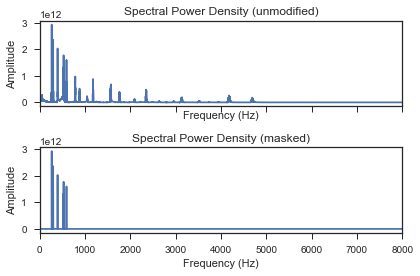

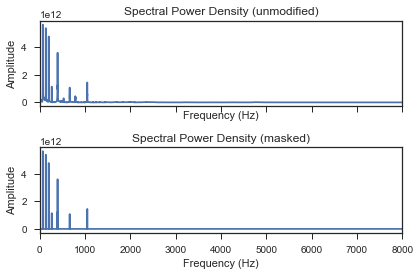

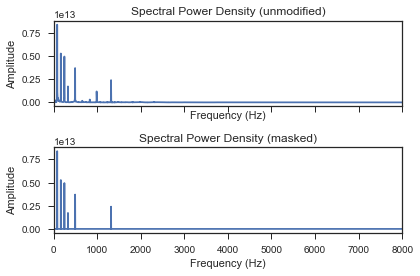

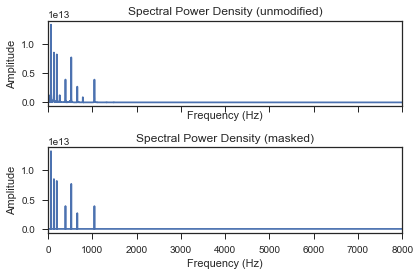

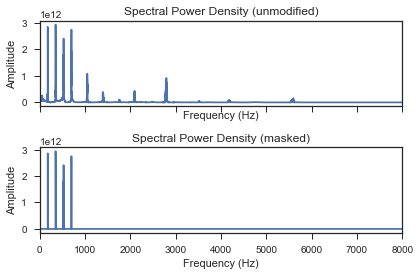

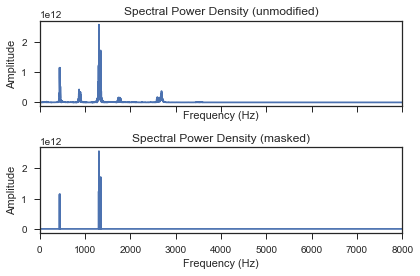

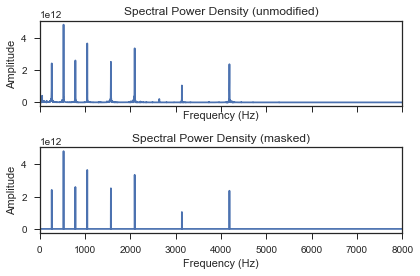

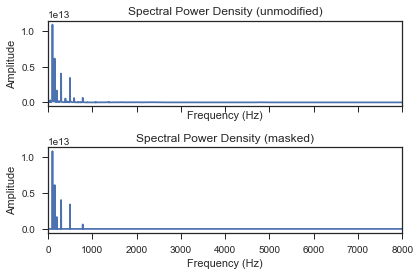

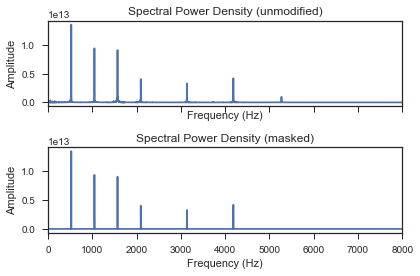

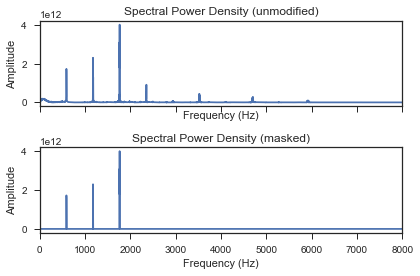

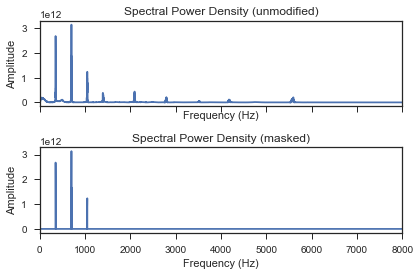

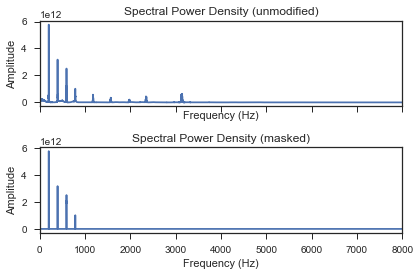

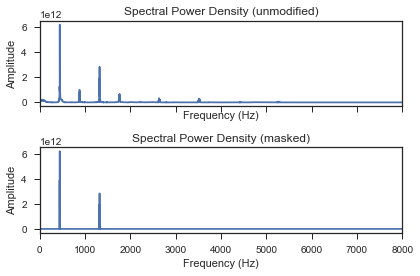

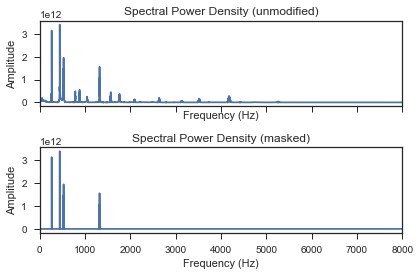

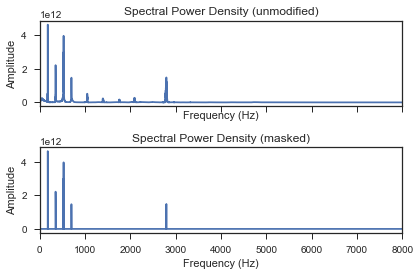

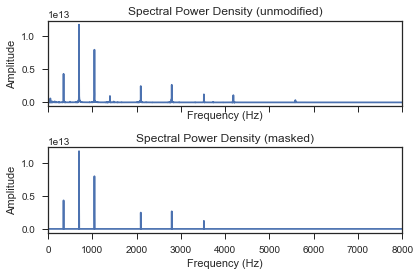

In [7]:
#loop over all sound files and call get_notes to return
#a response indicating the detected musical notes
for index in range(len(sound_files)):
    get_notes(sound_files[index])
    
#this correctly identifies the notes in the four labeled sound files
#shown below the printed responses for each sound file is are pairs of
#plots showing the spectral power density of the input file and the
#spectral power density of the same file after we've selected only 
#the highest amplitude frequencies, i.e. masked (although harmonics 
#may still be present in the masked plots)